In [ ]:
# pip install umap-learn hdbscan transformers

In [1]:
import os
import cv2
import random
import numpy as np
import skimage
import umap
import hdbscan
import pandas as pd
import torch

from glob import glob
from collections import Counter
from tqdm.auto import tqdm
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize

/home/wockd/anaconda3/envs/test/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-04 13:39:45.711101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733287185.745525    4704 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733287185.756237    4704 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 13:39:45.834019: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-criti

In [2]:
BATCH_SIZE = 8
SEED = 42

## CLIP 모델과 UMAP을 통한 이미지 클러스터링 하기

### Clip 모델을 통해 임베딩 하기

In [4]:
clip_model = CLIPModel.from_pretrained("geolocal/StreetCLIP")
clip_model.to('cuda')
clip_processor = CLIPProcessor.from_pretrained("geolocal/StreetCLIP")

AssertionError: Torch not compiled with CUDA enabled

In [4]:
image_paths = sorted(glob('/home/wockd/Documents/dacon/train_gt/*.png'))

### 하이퍼 파라미터 설정, 데이터 로드 및 전처리

In [5]:
SEED=42
N_SPLIT=5
BATCH_SIZE=8
IMAGE_PREPROC_MEAN=0.5
IMAGE_PREPROC_STD=0.225
MIN_POLYGON_BBOX_SIZE = 50

In [6]:
# 데이터 경로 설정
TRAIN_DATA_DIR = '/home/wockd/Documents/dacon/train_gt'  # 학습용 원본 이미지 경로
VALID_DATA_DIR = f'./data/valid_input/{SEED=}-{MIN_POLYGON_BBOX_SIZE=}'  # 검증 데이터 경로
TEST_DATA_DIR = '/home/wockd/Documents/dacon/test_input'  # 테스트 데이터 경로
SUBMISSON_DATA_DIR = './submission'  # 제출 파일 저장 경로

# 실험 설정
EXPERIMENT_NAME = 'img_aug'  # 현재 실험의 이름

In [8]:
train_embeddings = np.load('./preproc/train_embeddings.npy')

### UMAP을 통해 이미지 임베딩을 클러스터링하기

In [9]:
clusterable_embedding = umap.UMAP(
    n_neighbors=5,
    min_dist=0.0,
    n_components=2,
    random_state=SEED,
).fit_transform(train_embeddings)

/home/wockd/anaconda3/envs/test/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/wockd/anaconda3/envs/test/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/wockd/anaconda3/envs/test/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/wockd/anaconda3/envs/test/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Con

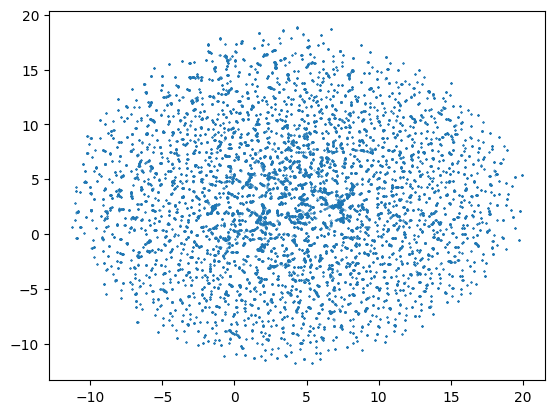

In [10]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1)

In [11]:
labels = hdbscan.HDBSCAN(
    min_cluster_size=5,
).fit_predict(clusterable_embedding)

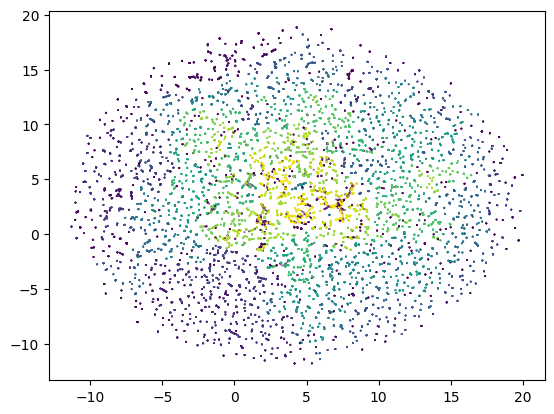

In [12]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=labels, s=0.1)

In [13]:
len(set(labels)), sum(labels==-1)

(2443, np.int64(2164))

In [14]:
counter = Counter([label for label in labels if label!=-1])

In [15]:
min(counter.values()), np.median(list(counter.values())), max(counter.values())

(5, np.float64(10.0), 72)

## 클러스터 별 이미지 확인 및 저장하기

label is 0


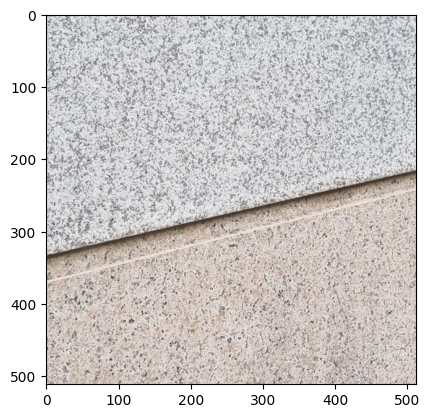

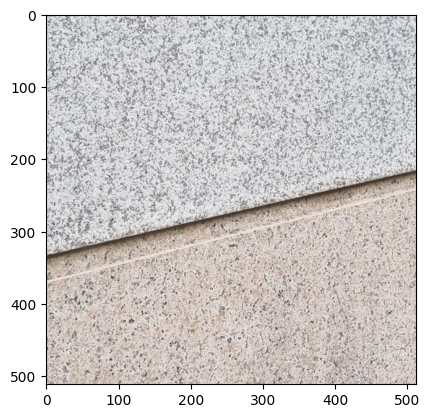

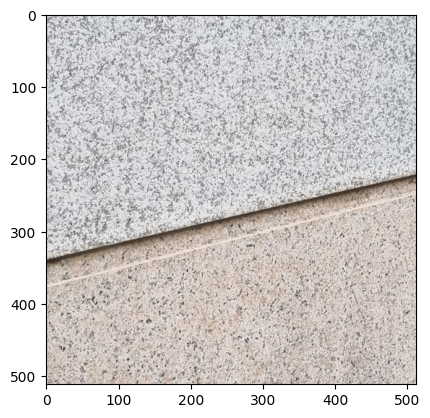

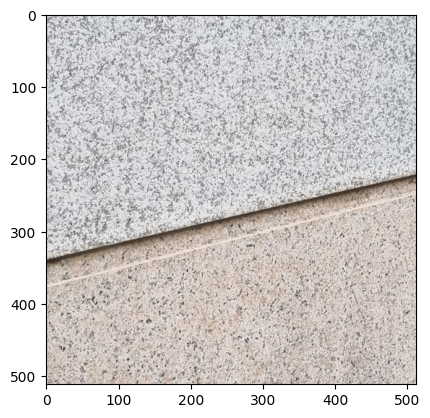

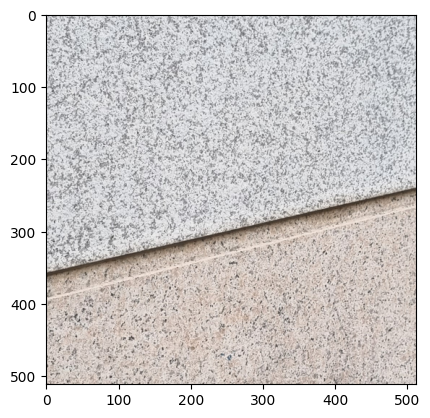

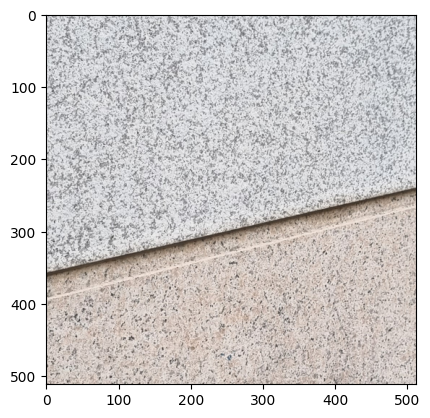

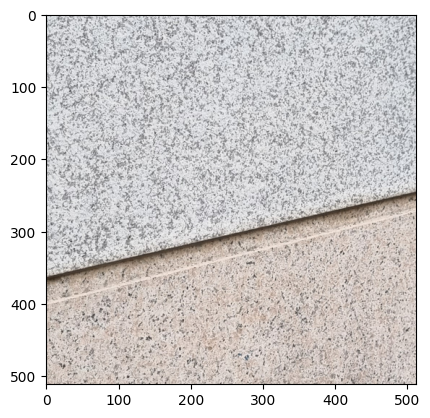

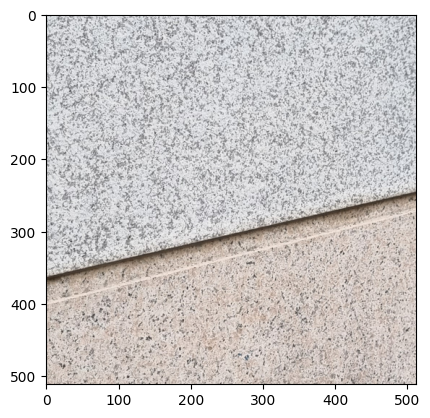

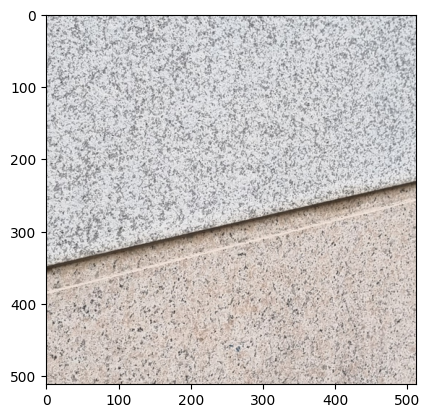

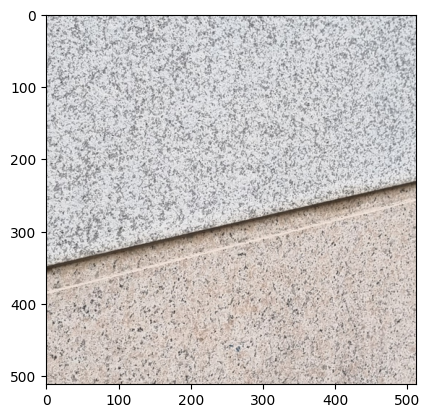

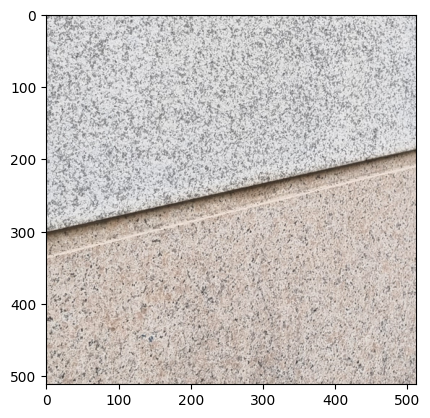

label is 1


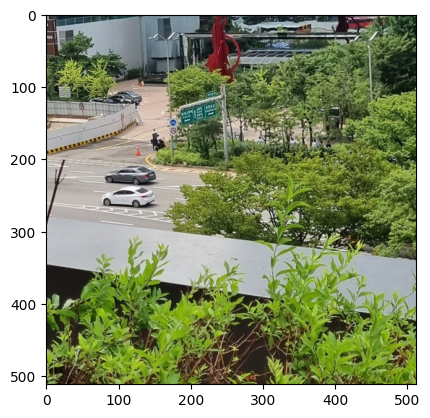

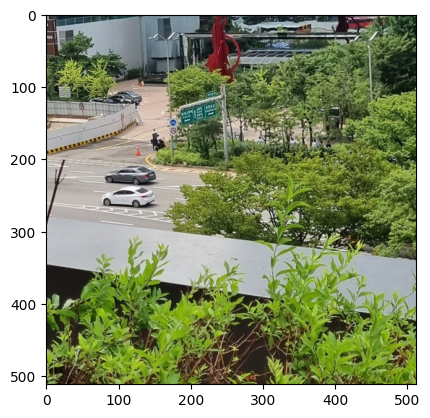

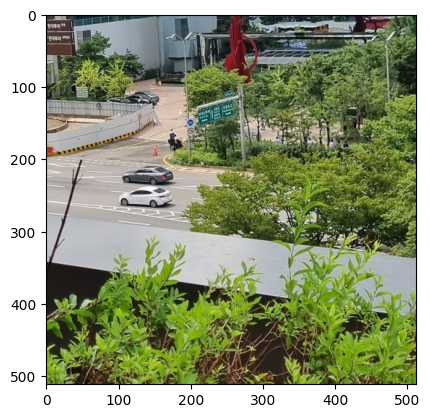

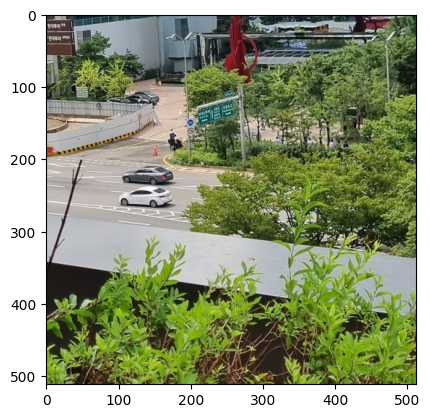

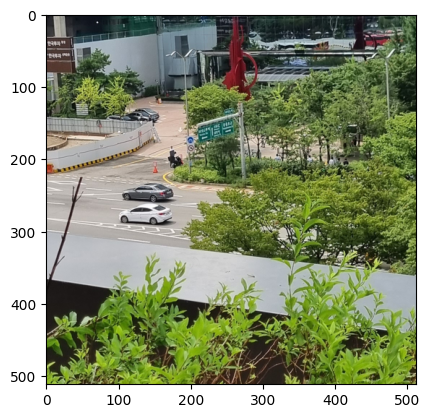

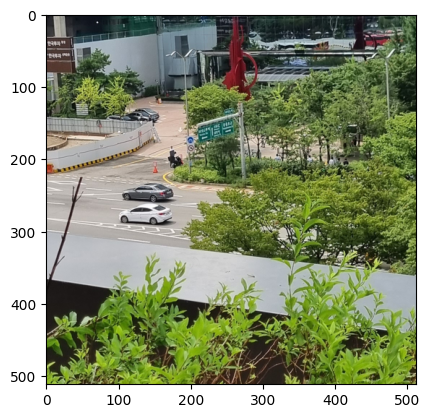

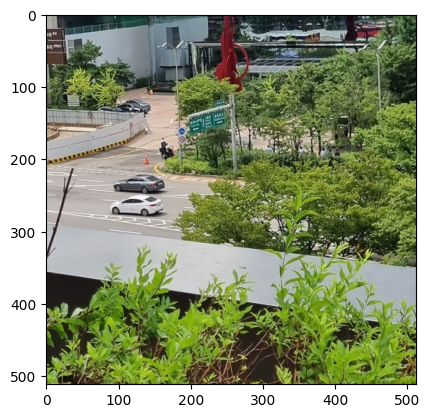

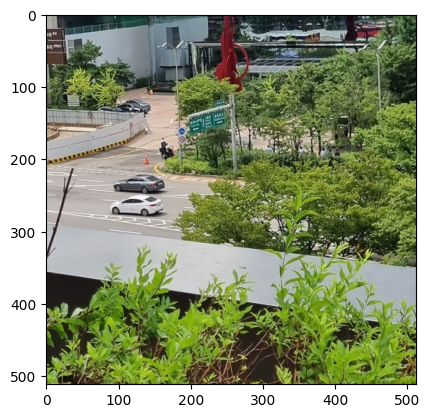

In [16]:
print('label is 0')
for image_path in np.array(image_paths)[labels==0]:
    image = Image.open(image_path)
    plt.imshow(image)
    plt.show()
print('label is 1')
for image_path in np.array(image_paths)[labels==1]:
    image = Image.open(image_path)
    plt.imshow(image)
    plt.show()

In [17]:
train_df = pd.DataFrame(columns=['image','label'])

In [18]:
train_df['image'] = [os.path.basename(image_path) for image_path in image_paths]
train_df['label'] = labels

In [19]:
train_df.to_csv('./preproc/train_preproc.csv', index=False)

In [20]:
test_image_paths = sorted(glob('/home/wockd/Documents/dacon/test_input/*.png'))

In [21]:
test_df = pd.DataFrame(columns=['image'])

In [22]:
test_df['image'] = [os.path.basename(image_path) for image_path in test_image_paths]

In [23]:
test_df.to_csv('./preproc/test_preproc.csv', index=False)

# 2. 모델 학습 코드

In [24]:
import os
import math
import random
import zipfile
import cv2
import numpy as np
import skimage
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L
import segmentation_models_pytorch as smp

from tqdm.auto import tqdm
from glob import glob
from PIL import Image
from polygenerator import (
    random_polygon,
    random_star_shaped_polygon,
    random_convex_polygon,
)
from sklearn.model_selection import KFold
from skimage.metrics import structural_similarity as ski_ssim
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

from matplotlib import pyplot as plt

In [25]:
torch.set_float32_matmul_precision('medium')

In [26]:
import albumentations as A
import random
import numpy as np
from PIL import Image
import skimage.draw

# albumentations 기반 증강 파이프라인 정의
def get_augmentation():
    return A.Compose([
        # 이미지 회전 (rotation)
        A.RandomRotate90(p=0.5),  # 90도 회전, 확률 50%
        
        # 이미지 뒤집기 (flip)
        A.HorizontalFlip(p=0.5),  # 수평 뒤집기, 확률 50%
        A.VerticalFlip(p=0.5),  # 수직 뒤집기, 확률 50%
        
        # 크기 조정 (scale)
        A.RandomScale(scale_limit=0.2, p=0.5),  # 20% 이내의 크기 조정, 확률 50%
        
        # 크롭 (crop)
        A.Resize(width=256, height=256, p=1.0),  # 300x300 크기로 랜덤 크롭, 확률 50%
        
        # 밝기/대비 조정
        A.RandomBrightnessContrast(p=0.2),  # 밝기 및 대비를 랜덤으로 조정
        
        # 색상 변화
        A.ColorJitter(p=0.2),  # 색상 랜덤 변화
    ])

# 증강 적용 함수
def augment_image(image):
    # albumentations 증강 파이프라인
    transform = get_augmentation()
    
    # PIL 이미지를 numpy 배열로 변환 (albumentations는 numpy 배열을 사용)
    image_np = np.array(image)
    
    # 이미지 증강 적용
    augmented = transform(image=image_np)
    
    # 증강된 이미지 결과 반환
    augmented_image = Image.fromarray(augmented['image'])
    return augmented_image


def get_input_image(image, min_polygon_bbox_size=50):

    image = augment_image(image)  # 이미지를 증강 후 사용


    width, height = image.size
    while True:
        bbox_x1 = random.randint(0, width-min_polygon_bbox_size)
        bbox_y1 = random.randint(0, height-min_polygon_bbox_size)
        bbox_x2 = random.randint(bbox_x1, width)  # Ensure width > 10
        bbox_y2 = random.randint(bbox_y1, height)  # Ensure height > 10
        if (bbox_x2-bbox_x1)<min_polygon_bbox_size or (bbox_y2-bbox_y1)<min_polygon_bbox_size:
            continue
        
        mask_bbox = [bbox_x1, bbox_y1, bbox_x2, bbox_y2]
        mask_width = bbox_x2-bbox_x1
        mask_height = bbox_y2-bbox_y1
    
        num_points = random.randint(3,20)
        polygon_func = random.choice([
            random_polygon,
            random_star_shaped_polygon,
            random_convex_polygon
        ])
        polygon = polygon_func(num_points=num_points) #scaled 0~1
        polygon = [(round(r*mask_width), round(c*mask_height)) for r,c in polygon]
        polygon_mask = skimage.draw.polygon2mask((mask_width, mask_height), polygon)
        if np.sum(polygon_mask)>(min_polygon_bbox_size//2)**2:
            break
    full_image_mask = np.zeros((width, height), dtype=np.uint8)
    full_image_mask[bbox_x1:bbox_x2, bbox_y1:bbox_y2] = polygon_mask
    
    image_gray = image.convert('L')
    image_gray_array = np.array(image_gray)  # Convert to numpy array for manipulation
    random_color = random.randint(0, 255)  # Random grayscale color
    image_gray_array[full_image_mask == 1] = random_color
    image_gray_masked = Image.fromarray(image_gray_array)

    return {
        'image_gt':image,
        'mask':full_image_mask,
        'image_gray':image_gray,
        'image_gray_masked':image_gray_masked
    }

In [ ]:
augmented_image = augmented['image']

NameError: name 'augmented' is not defined

In [28]:
def get_ssim_score(true, pred):
    # 전체 RGB 이미지를 사용해 SSIM 계산 (channel_axis=-1)
    ssim_value = ski_ssim(true, pred, channel_axis=-1, data_range=pred.max() - pred.min())
    return ssim_value

def get_masked_ssim_score(true, pred, mask):
    # 손실 영역의 좌표에서만 RGB 채널별 픽셀 값 추출
    true_masked_pixels = true[mask > 0]
    pred_masked_pixels = pred[mask > 0]
    
    # 손실 영역 픽셀만으로 SSIM 계산 (채널축 사용)
    ssim_value = ski_ssim(
        true_masked_pixels, 
        pred_masked_pixels, 
        channel_axis=-1, 
        data_range=pred.max() - pred.min()
    )
    return ssim_value

def get_histogram_similarity(true, pred, cvt_color=cv2.COLOR_RGB2HSV):
    # BGR 이미지를 HSV로 변환
    true_hsv = cv2.cvtColor(true, cvt_color)
    pred_hsv = cv2.cvtColor(pred, cvt_color)

    # H 채널에서 히스토그램 계산 및 정규화
    hist_true = cv2.calcHist([true_hsv], [0], None, [180], [0, 180])
    hist_pred = cv2.calcHist([pred_hsv], [0], None, [180], [0, 180])
    hist_true = cv2.normalize(hist_true, hist_true).flatten()
    hist_pred = cv2.normalize(hist_pred, hist_pred).flatten()

    # 히스토그램 간 유사도 계산 (상관 계수 사용)
    similarity = cv2.compareHist(hist_true, hist_pred, cv2.HISTCMP_CORREL)
    return similarity

### 하이퍼 파라미터 설정, 데이터 로드 및 전처리

In [29]:
SEED=42
N_SPLIT=5
BATCH_SIZE=8
IMAGE_PREPROC_MEAN=0.5
IMAGE_PREPROC_STD=0.225
MIN_POLYGON_BBOX_SIZE = 50

In [31]:
# 데이터 경로 설정
TRAIN_DATA_DIR = '/home/wockd/Documents/dacon/train_gt'  # 학습용 원본 이미지 경로
VALID_DATA_DIR = f'./data/valid_input/{SEED=}-{MIN_POLYGON_BBOX_SIZE=}'  # 검증 데이터 경로
TEST_DATA_DIR = '/home/wockd/Documents/dacon/test_input'  # 테스트 데이터 경로
SUBMISSON_DATA_DIR = './submission'  # 제출 파일 저장 경로

# 실험 설정
EXPERIMENT_NAME = 'img_aug'  # 현재 실험의 이름

In [32]:
L.seed_everything(SEED)

Seed set to 42


42

In [33]:
train_df = pd.read_csv('./preproc/train_preproc.csv')
test_df = pd.read_csv('./preproc/test_preproc.csv')

In [34]:
os.makedirs(VALID_DATA_DIR, exist_ok=True)
for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    img_path = train_df.iloc[idx, 0]
    img_path = os.path.join(TRAIN_DATA_DIR, img_path)
    save_image_name = os.path.basename(img_path).replace('TRAIN', 'VALID').replace('png','npy')
    save_image_path = f'{VALID_DATA_DIR}/{save_image_name}'
    if os.path.exists(save_image_path):
        continue
    image = Image.open(img_path)
    valid_input_image = get_input_image(image, MIN_POLYGON_BBOX_SIZE)
    np.save(save_image_path, valid_input_image)

100%|██████████| 29603/29603 [00:01<00:00, 23740.66it/s]


In [35]:
train_df_outlier = train_df[train_df['label']==-1]
train_df = train_df[train_df['label']!=-1]

In [36]:
kf = KFold(n_splits=N_SPLIT, shuffle=True, random_state=SEED)

In [37]:
for fold_idx, (train_indices, valid_indices) in enumerate(kf.split(train_df['image'], train_df['label'])):
    train_fold_df = train_df.iloc[train_indices].reset_index(drop=True)
    valid_fold_df = train_df.iloc[valid_indices].reset_index(drop=True)
    valid_fold_df['image'] = valid_fold_df['image'].apply(lambda x: x.replace('TRAIN', 'VALID').replace('png', 'npy'))
    valid_fold_df = valid_fold_df.drop_duplicates('label') # for fast validation
    # train_fold_df = pd.concat([train_fold_df,train_df_outlier],axis=0).reset_index(drop=True)
    break

## 데이터셋 클래스 작성 및 초기화

In [38]:


class CustomImageDataset(Dataset):
    def __init__(self, df, data_dir='./data/train_gt', mode='train', min_polygon_bbox_size=MIN_POLYGON_BBOX_SIZE):
        self.df = df
        self.data_dir = data_dir
        self.mode = mode
        self.min_polygon_bbox_size = min_polygon_bbox_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path and label
        img_path = self.df.iloc[idx, 0]  # Assuming first column is the path
        img_path = os.path.join(self.data_dir, img_path)
        
        # Apply augmentation if in training mode
        if self.mode == 'train':
            image = Image.open(img_path)
            image_input = get_input_image(image, self.min_polygon_bbox_size)
            return image_input

        elif self.mode == 'valid':
            image_input = self.load_input_image(img_path)
            return image_input
        elif self.mode == 'test':
            image = Image.open(img_path)
            return {
                'image_gray_masked':image
            }

    def load_input_image(self, img_input_path):
        image_input = np.load(img_input_path, allow_pickle=True)
        return image_input.item()
    

In [39]:
train_dataset = CustomImageDataset(train_fold_df, data_dir=TRAIN_DATA_DIR, mode='train')
valid_dataset = CustomImageDataset(valid_fold_df, data_dir=VALID_DATA_DIR, mode='valid')
test_dataset = CustomImageDataset(test_df, data_dir=TEST_DATA_DIR, mode='test')

### 데이터 시각화

In [40]:
for idx, data in tqdm(enumerate(valid_dataset)):
    break

0it [00:00, ?it/s]


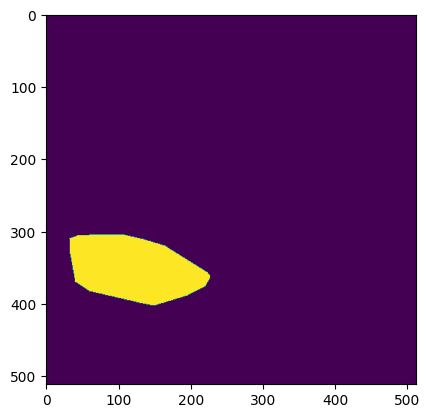

In [41]:
plt.imshow(data['mask'])

## 데이터로더 작성 및 초기화

In [42]:
class CollateFn:
    def __init__(self, mean=IMAGE_PREPROC_MEAN, std=IMAGE_PREPROC_STD, mode='train'):
        self.mode = mode
        self.mean = mean
        self.std = std

    def __call__(self, examples):
        if self.mode =='train' or self.mode=='valid':
            # Initialize lists to store each component of the batch
            masks= []
            images_gray = []
            images_gray_masked = []
            images_gt = []
    
            for example in examples:
                # Assuming each example is a dictionary with keys 'mask', 'image_gray', 'image_gray_masked', 'image_gt'
                masks.append(example['mask'])
                images_gray.append(self.normalize_image(example['image_gray']))
                images_gray_masked.append(self.normalize_image(example['image_gray_masked']))
                images_gt.append(self.normalize_image(np.array(example['image_gt'])))

            return {
                'masks': torch.from_numpy(np.stack(masks)).long(),
                'images_gray': torch.from_numpy(np.stack(images_gray)).unsqueeze(1).float(),
                'images_gray_masked': torch.from_numpy(np.stack(images_gray_masked)).unsqueeze(1).float(),
                'images_gt': torch.from_numpy(np.stack(images_gt)).permute(0,3,1,2).float()
            }

        elif self.mode == 'test':
            images_gray_masked = []
            for example in examples:
                images_gray_masked.append(self.normalize_image(example['image_gray_masked']))
            return {
                'images_gray_masked': torch.from_numpy(np.stack(images_gray_masked)).unsqueeze(1).float(),
            }

    def normalize_image(self, image):
        return (np.array(image)/255-self.mean)/self.std

In [43]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=CollateFn(mode='train'))
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE*2, shuffle=False, collate_fn=CollateFn(mode='valid'))
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, collate_fn=CollateFn(mode='test'))

## 모델 작성 및 초기화

In [49]:
class LitIRModel(L.LightningModule):
    def __init__(self, model_1, model_2, image_mean=IMAGE_PREPROC_MEAN, image_std=IMAGE_PREPROC_STD):
        super().__init__()
        self.model_1 = model_1
        self.model_2 = model_2
        self.image_mean=image_mean
        self.image_std=image_std

    def forward(self, images_gray_masked):
        images_gray_restored = self.model_1(images_gray_masked)+images_gray_masked
        images_restored = self.model_2(images_gray_restored)
        return images_gray_restored, images_restored
        
    def unnormalize(self, output, round=False):
        image_restored = ((output*self.image_std+self.image_mean)*255).clamp(0,255)
        if round:
            image_restored = torch.round(image_restored)
        return image_restored
    
    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=1e-5)
        return opt

    def training_step(self, batch, batch_idx):
        masks, images_gray_masked, images_gray, images_gt = batch['masks'], batch['images_gray_masked'], batch['images_gray'], batch['images_gt']
        images_gray_restored, images_restored = self(images_gray_masked)
        
        loss_pixel_gray = F.l1_loss(images_gray, images_gray_restored, reduction='mean') * 0.5 + F.mse_loss(images_gray, images_gray_restored, reduction='mean') * 0.5
        loss_pixel = F.l1_loss(images_gt, images_restored, reduction='mean') * 0.5 + F.mse_loss(images_gt, images_restored, reduction='mean') * 0.5
        loss = loss_pixel_gray * 0.5 + loss_pixel * 0.5

        self.log("train_loss", loss, on_step=True, on_epoch=False)
        self.log("train_loss_pixel_gray", loss_pixel_gray, on_step=True, on_epoch=False)
        self.log("train_loss_pixel", loss_pixel, on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        masks, images_gray_masked, images_gt = batch['masks'], batch['images_gray_masked'], batch['images_gt']
        images_gray_restored, images_restored = self(images_gray_masked)
        images_gt, images_restored = self.unnormalize(images_gt, round=True), self.unnormalize(images_restored, round=True)
        masks_np = masks.detach().cpu().numpy()
        images_gt_np = images_gt.detach().cpu().permute(0,2,3,1).float().numpy().astype(np.uint8)
        images_restored_np = images_restored.detach().cpu().permute(0,2,3,1).float().numpy().astype(np.uint8)
        total_ssim_score = 0
        masked_ssim_score = 0
        hist_sim_score = 0
        for image_gt_np, image_restored_np, mask_np in zip(images_gt_np, images_restored_np, masks_np):
            total_ssim_score += get_ssim_score(image_gt_np, image_restored_np) / len(images_gt)
            masked_ssim_score += get_masked_ssim_score(image_gt_np, image_restored_np, mask_np)/ len(images_gt)
            hist_sim_score += get_histogram_similarity(image_gt_np, image_restored_np, cv2.COLOR_RGB2HSV)/ len(images_gt)
        score = total_ssim_score * 0.2 + masked_ssim_score * 0.4 + hist_sim_score * 0.4
        self.log(f"val_score", score, on_step=False, on_epoch=True)
        self.log(f"val_total_ssim_score", total_ssim_score, on_step=False, on_epoch=True)
        self.log(f"val_masked_ssim_score", masked_ssim_score, on_step=False, on_epoch=True)
        self.log(f"val_hist_sim_score", hist_sim_score, on_step=False, on_epoch=True)
        return score

    def predict_step(self, batch, batch_idx):
        images_gray_masked = batch['images_gray_masked']
        images_gray_restored, images_restored = self(images_gray_masked)
        images_restored = self.unnormalize(images_restored, round=True)
        images_restored_np = images_restored.detach().cpu().permute(0,2,3,1).float().numpy().astype(np.uint8)
        return images_restored_np

In [50]:
model_1 = smp.Unet(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=1,                  
    classes=1,                      
)

# gray -> color
model_2 = smp.Unet(
    encoder_name="resnet34",         
    encoder_weights="imagenet",     
    in_channels=1,                  
    classes=3,                      
)

lit_ir_model = LitIRModel(model_1=model_1, model_2=model_2)

## 모델 학습

In [51]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_score',
    mode='max',
    dirpath='./checkpoint/',
    filename=f'image_augmentation_smp-unet-resnet34-{fold_idx=}-{SEED=}'+'-{epoch:02d}-{val_score:.4f}',
    save_top_k=1,
    save_weights_only=True,
    verbose=True
)
earlystopping_callback = EarlyStopping(monitor="val_score", mode="max", patience=5)

In [52]:
trainer = L.Trainer(max_epochs=100, precision='bf16-mixed', callbacks=[checkpoint_callback, earlystopping_callback], detect_anomaly=False)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [53]:
trainer.fit(lit_ir_model, train_dataloader, valid_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params | Mode 
-----------------------------------------
0 | model_1 | Unet | 24.4 M | train
1 | model_2 | Unet | 24.4 M | train
-----------------------------------------
48.9 M    Trainable params
0         Non-trainable params
48.9 M    Total params
195.442   Total estimated model params size (MB)
376       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 2744/2744 [07:47<00:00,  5.86it/s, v_num=10]     

Epoch 0, global step 2744: 'val_score' reached 0.32270 (best 0.32270), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=00-val_score=0.3227.ckpt' as top 1


Epoch 1: 100%|██████████| 2744/2744 [07:53<00:00,  5.80it/s, v_num=10]

Epoch 1, global step 5488: 'val_score' reached 0.39596 (best 0.39596), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=01-val_score=0.3960.ckpt' as top 1


Epoch 2: 100%|██████████| 2744/2744 [08:01<00:00,  5.70it/s, v_num=10]

Epoch 2, global step 8232: 'val_score' reached 0.42821 (best 0.42821), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=02-val_score=0.4282.ckpt' as top 1


Epoch 3: 100%|██████████| 2744/2744 [07:54<00:00,  5.78it/s, v_num=10]

Epoch 3, global step 10976: 'val_score' reached 0.43570 (best 0.43570), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=03-val_score=0.4357.ckpt' as top 1


Epoch 4: 100%|██████████| 2744/2744 [07:58<00:00,  5.73it/s, v_num=10]

Epoch 4, global step 13720: 'val_score' reached 0.45288 (best 0.45288), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=04-val_score=0.4529.ckpt' as top 1


Epoch 5: 100%|██████████| 2744/2744 [07:32<00:00,  6.06it/s, v_num=10]

Epoch 5, global step 16464: 'val_score' was not in top 1


Epoch 6: 100%|██████████| 2744/2744 [07:32<00:00,  6.07it/s, v_num=10]

Epoch 6, global step 19208: 'val_score' reached 0.46971 (best 0.46971), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=06-val_score=0.4697.ckpt' as top 1


Epoch 7: 100%|██████████| 2744/2744 [07:32<00:00,  6.07it/s, v_num=10]

Epoch 7, global step 21952: 'val_score' reached 0.47515 (best 0.47515), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=07-val_score=0.4751.ckpt' as top 1


Epoch 8: 100%|██████████| 2744/2744 [07:32<00:00,  6.06it/s, v_num=10]

Epoch 8, global step 24696: 'val_score' reached 0.47554 (best 0.47554), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=08-val_score=0.4755.ckpt' as top 1


Epoch 9: 100%|██████████| 2744/2744 [07:33<00:00,  6.06it/s, v_num=10]

Epoch 9, global step 27440: 'val_score' reached 0.48256 (best 0.48256), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=09-val_score=0.4826.ckpt' as top 1


Epoch 10: 100%|██████████| 2744/2744 [07:33<00:00,  6.06it/s, v_num=10]

Epoch 10, global step 30184: 'val_score' reached 0.49715 (best 0.49715), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=10-val_score=0.4972.ckpt' as top 1


Epoch 11: 100%|██████████| 2744/2744 [07:32<00:00,  6.07it/s, v_num=10]

Epoch 11, global step 32928: 'val_score' was not in top 1


Epoch 12: 100%|██████████| 2744/2744 [07:29<00:00,  6.10it/s, v_num=10]

Epoch 12, global step 35672: 'val_score' reached 0.49917 (best 0.49917), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=12-val_score=0.4992.ckpt' as top 1


Epoch 13: 100%|██████████| 2744/2744 [07:32<00:00,  6.06it/s, v_num=10]

Epoch 13, global step 38416: 'val_score' reached 0.49976 (best 0.49976), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=13-val_score=0.4998.ckpt' as top 1


Epoch 14: 100%|██████████| 2744/2744 [07:34<00:00,  6.04it/s, v_num=10]

Epoch 14, global step 41160: 'val_score' reached 0.50314 (best 0.50314), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=14-val_score=0.5031.ckpt' as top 1


Epoch 15: 100%|██████████| 2744/2744 [07:32<00:00,  6.06it/s, v_num=10]

Epoch 15, global step 43904: 'val_score' reached 0.50391 (best 0.50391), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=15-val_score=0.5039.ckpt' as top 1


Epoch 16: 100%|██████████| 2744/2744 [07:33<00:00,  6.06it/s, v_num=10]

Epoch 16, global step 46648: 'val_score' reached 0.51167 (best 0.51167), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=16-val_score=0.5117.ckpt' as top 1


Epoch 17: 100%|██████████| 2744/2744 [07:33<00:00,  6.05it/s, v_num=10]

Epoch 17, global step 49392: 'val_score' reached 0.51433 (best 0.51433), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=17-val_score=0.5143.ckpt' as top 1


Epoch 18: 100%|██████████| 2744/2744 [07:32<00:00,  6.06it/s, v_num=10]

Epoch 18, global step 52136: 'val_score' was not in top 1


Epoch 19: 100%|██████████| 2744/2744 [07:35<00:00,  6.03it/s, v_num=10]

Epoch 19, global step 54880: 'val_score' reached 0.52060 (best 0.52060), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=19-val_score=0.5206.ckpt' as top 1


Epoch 20: 100%|██████████| 2744/2744 [07:31<00:00,  6.07it/s, v_num=10]

Epoch 20, global step 57624: 'val_score' was not in top 1


Epoch 21: 100%|██████████| 2744/2744 [07:33<00:00,  6.05it/s, v_num=10]

Epoch 21, global step 60368: 'val_score' reached 0.52382 (best 0.52382), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=21-val_score=0.5238.ckpt' as top 1


Epoch 22: 100%|██████████| 2744/2744 [07:33<00:00,  6.05it/s, v_num=10]

Epoch 22, global step 63112: 'val_score' reached 0.52586 (best 0.52586), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=22-val_score=0.5259.ckpt' as top 1


Epoch 23: 100%|██████████| 2744/2744 [07:32<00:00,  6.06it/s, v_num=10]

Epoch 23, global step 65856: 'val_score' was not in top 1


Epoch 24: 100%|██████████| 2744/2744 [07:30<00:00,  6.09it/s, v_num=10]

Epoch 24, global step 68600: 'val_score' was not in top 1


Epoch 25: 100%|██████████| 2744/2744 [07:33<00:00,  6.05it/s, v_num=10]

Epoch 25, global step 71344: 'val_score' was not in top 1


Epoch 26: 100%|██████████| 2744/2744 [07:33<00:00,  6.05it/s, v_num=10]

Epoch 26, global step 74088: 'val_score' reached 0.53019 (best 0.53019), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=26-val_score=0.5302.ckpt' as top 1


Epoch 27: 100%|██████████| 2744/2744 [07:33<00:00,  6.05it/s, v_num=10]

Epoch 27, global step 76832: 'val_score' was not in top 1


Epoch 28: 100%|██████████| 2744/2744 [07:32<00:00,  6.06it/s, v_num=10]

Epoch 28, global step 79576: 'val_score' was not in top 1


Epoch 29: 100%|██████████| 2744/2744 [07:33<00:00,  6.05it/s, v_num=10]

Epoch 29, global step 82320: 'val_score' reached 0.53230 (best 0.53230), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=29-val_score=0.5323.ckpt' as top 1


Epoch 30: 100%|██████████| 2744/2744 [07:30<00:00,  6.09it/s, v_num=10]

Epoch 30, global step 85064: 'val_score' reached 0.53543 (best 0.53543), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=30-val_score=0.5354.ckpt' as top 1


Epoch 31: 100%|██████████| 2744/2744 [07:34<00:00,  6.04it/s, v_num=10]

Epoch 31, global step 87808: 'val_score' was not in top 1


Epoch 32: 100%|██████████| 2744/2744 [07:32<00:00,  6.06it/s, v_num=10]

Epoch 32, global step 90552: 'val_score' reached 0.53559 (best 0.53559), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=32-val_score=0.5356.ckpt' as top 1


Epoch 33: 100%|██████████| 2744/2744 [07:55<00:00,  5.77it/s, v_num=10]

Epoch 33, global step 93296: 'val_score' reached 0.53773 (best 0.53773), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=33-val_score=0.5377.ckpt' as top 1


Epoch 34: 100%|██████████| 2744/2744 [07:36<00:00,  6.01it/s, v_num=10]

Epoch 34, global step 96040: 'val_score' was not in top 1


Epoch 35: 100%|██████████| 2744/2744 [07:32<00:00,  6.06it/s, v_num=10]

Epoch 35, global step 98784: 'val_score' was not in top 1


Epoch 36: 100%|██████████| 2744/2744 [07:29<00:00,  6.11it/s, v_num=10]

Epoch 36, global step 101528: 'val_score' reached 0.54274 (best 0.54274), saving model to '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=36-val_score=0.5427.ckpt' as top 1


Epoch 37: 100%|██████████| 2744/2744 [07:32<00:00,  6.07it/s, v_num=10]

Epoch 37, global step 104272: 'val_score' was not in top 1


Epoch 38: 100%|██████████| 2744/2744 [07:32<00:00,  6.06it/s, v_num=10]

Epoch 38, global step 107016: 'val_score' was not in top 1


Epoch 39: 100%|██████████| 2744/2744 [07:31<00:00,  6.08it/s, v_num=10]

Epoch 39, global step 109760: 'val_score' was not in top 1


Epoch 40: 100%|██████████| 2744/2744 [07:31<00:00,  6.07it/s, v_num=10]

Epoch 40, global step 112504: 'val_score' was not in top 1


Epoch 41: 100%|██████████| 2744/2744 [07:32<00:00,  6.07it/s, v_num=10]

Epoch 41, global step 115248: 'val_score' was not in top 1


Epoch 41: 100%|██████████| 2744/2744 [07:32<00:00,  6.07it/s, v_num=10]


In [54]:
lit_ir_model = LitIRModel.load_from_checkpoint(
    '/home/wockd/Documents/dacon/checkpoint/image_augmentation_smp-unet-resnet34-fold_idx=0-SEED=42-epoch=36-val_score=0.5427.ckpt',
    model_1=model_1,
    model_2=model_2,
)

In [55]:
predictions = trainer.predict(lit_ir_model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wockd/anaconda3/envs/test/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 7/7 [00:01<00:00,  6.07it/s]


In [56]:
predictions = np.concatenate(predictions)

In [57]:
submission_dir = os.path.join(SUBMISSON_DATA_DIR, EXPERIMENT_NAME)
submission_file = f'{SUBMISSON_DATA_DIR}/{EXPERIMENT_NAME}.zip'
os.makedirs(submission_dir, exist_ok=True)

In [58]:
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    image_pred = Image.fromarray(predictions[idx])
    image_pred.save(os.path.join(submission_dir, row['image']), "PNG")

100%|██████████| 100/100 [00:06<00:00, 15.96it/s]


In [59]:
# Step 3: Compress the directory into a ZIP file using glob
with zipfile.ZipFile(submission_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file_path in glob(f"{submission_dir}/*.png"):
        arcname = os.path.relpath(file_path, submission_dir)
        zipf.write(file_path, arcname)